# Morphological metrics for 3D volumetric ductal structures

This is a companion code of the paper:

*Quantification of airway structures by persistent homology with applications to the analysis of lumen surface irregularity and tree branching pattern in patients with chronic obstructive pulmonary disease*

by Shizuo Kaji, Naoya Tanabe (equal contribution), Susumu Sato, Tomoki Maetani, Yusuke Shiraishi, Tsuyoshi Oguma, Ryo Sakamoto, Motonari Fukui, Shigeo Muro, Toyohiro Hirai

In [ ]:
# execute this cell for setting up the environment
# (it is required only for the first run)
!pip install -U git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install scikit-fmm pynrrd persim skan


## Function definition

In [1]:
import skimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import pandas as pd
import os, zipfile, io, re, glob,pprint
import seaborn as sns
import persim
from genericpath import isfile
import networkx as nx
from tqdm.auto import tqdm
import joblib

import ductal_morphology as dm


In [2]:
# batch computation
def process_volume(volume_fn):
    CTID = os.path.splitext(os.path.basename(volume_fn))[0]
    if verbosity>0:
        print("\n",CTID)
    if skip_compute_airway:
        res={'CTID':CTID}
    else:
        volume, header = nrrd.read(volume_fn, index_order='C') # EXAMPLE: we load a volume from an NRRD file; replace this line to load other types of volumes in 3d numpy array
        skeleton_generation,volume_generation,origin,ac_gens,skeleton_MST = dm.create_generation_volumes(volume,graph_creation="nx",threshold=threshold,min_branch_children=min_branch_children, min_branch_separation=min_branch_separation, remove_trachea=remove_trachea,verbosity=verbosity)
        res={'CTID':CTID,'trachea_z':origin[0],'trachea_y':origin[1],'trachea_x':origin[2]}
        # restrict to the relevant generations
        skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
        binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
        # metrics
        res[f'volume_gen{max_gen}'] = binarised_volume.sum()
        res[f'surface_area_gen{max_gen}'] = round(dm.crofton_surface_area(binarised_volume))
        res[f'box_counting_dim_gen{max_gen}'] = dm.box_counting_dim(binarised_volume)
        radius_df, Tc, rse = dm.tapering_coeff(skeleton,binarised_volume,origin,min_radius=min_radius)
        res[f'tampering_coeff_gen{max_gen}']=Tc
        res[f'CV_radius_gen{max_gen}']=rse/radius_df['radius'].mean()
        for k,v in ac_gens.items():
            res[f'AC_gen{k}']=v

        # save aux files
        if save_intermediate:
            print("saving intermediate files...")
            #nrrd.write(os.path.join(output_dir,f"{CTID}_radius.nrrd"), radius, index_order='C')
            fig, ax = plt.subplots()
            sns.regplot(x='dist', y='log_radius', data=radius_df,ax=ax, scatter_kws={'s':2})
            ax.set_title(f'tapering coeff = {Tc}, RSE/mean(radius) = {res[f"CV_radius_gen{max_gen}"]}')
            fig.savefig(os.path.join(output_dir,f"{CTID}_dist_logRadius.jpg"))
            plt.close(fig)
            v = volume_generation.astype(np.int8)
            #v[(volume_generation>max_gen)]=0
            #v[skeleton_generation>0] = 1 # -skeleton_generation[skeleton_generation>0] # to make skeleton distinguishable, the values are shifted
            #v[origin] = 1
            nrrd.write(os.path.join(output_dir,f"{CTID}_generation.nrrd"), v, index_order='C')
            write_obj(v,level=0.5,filename=os.path.join(output_dir,f"{CTID}_generation.obj"))
            nrrd.write(os.path.join(output_dir,f"{CTID}_skeleton.nrrd"), skeleton_generation, index_order='C')
            volume[(volume_generation>max_gen)|(volume_generation==0)] = volume.min()
            nrrd.write(os.path.join(output_dir,f"{CTID}_volume_gen{max_gen}.nrrd"), volume, index_order='C')
            # plot graph
            # pos = nx.nx_agraph.graphviz_layout(skeleton_MST, prog="dot")
            # nx.draw(skeleton_MST, pos,with_labels = True)
            coords = {v: {i: skeleton_MST.nodes[v]['coords'][i] for i in range(3)} for v in skeleton_MST.nodes}
            nx.set_node_attributes(skeleton_MST,coords,'coords')
            nx.write_gexf(skeleton_MST,os.path.join(output_dir,f"{CTID}.gexf"))

    # PH computation
    if skip_compute_PH:
        PH=None
    else:
        print("computing PH...")
        if skip_compute_airway:
            PH=dm.compute_PH(CTID,maxdim=maxdim, PH_dir=PH_dir,OUTSIDE=OUTSIDE,recompute_PH=False, verbosity=verbosity)
        else:
            dist_vol = dm.geodesic_distance_transform(skeleton,binarised_volume,origin,outside_fill=OUTSIDE)
            PH=dm.compute_PH(CTID,dist_vol,maxdim=maxdim, PH_dir=PH_dir,OUTSIDE=OUTSIDE,recompute_PH=recompute_PH, verbosity=verbosity)
            if save_intermediate:
                for mode in dist_vol.keys():
                    nrrd.write(os.path.join(output_dir,f"{CTID}_{mode}_geodesic_dt_gen{max_gen}.nrrd"), dist_vol[mode], index_order='C')
        ress = dm.PH_metrics(PH,density=density, min_life=min_life, max_life=max_life, min_birth=min_birth, max_birth=max_birth, num_bins=num_bins, verbosity=verbosity)
        res.update(ress)                
    return(res,PH)

# reconstruct surface and write to an obj file with vertex colouring by generation (use MeshLab to open)
def write_obj(vol,level=0.5,filename=None):
    verts, faces, normals, values = skimage.measure.marching_cubes(vol,level=level)
    with open(filename, 'w') as f:
        for vert,val in zip(verts,values):
            col = mpl.colormaps['tab20'](int(val))
            f.write('v {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}\n'.format(vert[0], vert[1], vert[2], col[0], col[1], col[2]))
        for item in normals:
            f.write("vn {0} {1} {2}\n".format(item[0],item[1],item[2]))
        faces = faces+1 # index shift
        for item in faces:
            f.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0],item[1],item[2]))  
    #print(f'saved to {volume_fn}.obj')

# reconstruct surface and write to an OFF file with vertex colouring by generation (use MeshLab to open)
def write_off(vol,level=0.5,filename=None):
    verts, faces, normals, values = skimage.measure.marching_cubes(vol,level=level)
    plt.hist(values)
    plt.show()
    with open(filename, 'w') as fp:
        fp.write('COFF\n')
        fp.write(f'{len(verts)} {len(faces)} 0\n')
        for vert,val in zip(verts,values):
            col = mpl.colormaps['tab20'](int(val))
            fp.write('{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}\n'.format(vert[0], vert[1], vert[2], col[0],col[1],col[2]))
        for item in faces:
            fp.write("3 {} {} {}\n".format(item[0],item[1],item[2]))  
        fp.write('\n')
        
# boxplot 
def vboxplot(HS,group_name=None,group=None,density=False,ylabel="#cycles",title="",ax=None):
    tdf = []
    X = np.array(HS)
    if len(X.shape)==1:
        X = X.reshape((-1,1))
    if density:
        X = X / X.sum(axis=1).reshape(-1,1)
    if group is None:
        group = np.zeros(len(X))
    if group_name is None:
        group_name=sorted(list(set(group)))
    for i,c in enumerate(group_name):
        criteria = (group==c)
        for u in X[criteria]:
            for l,v in enumerate(u):
                tdf.append({"bin":l, "group":c, "val":v}) 
    tdf=pd.DataFrame(tdf)
    cmap = plt.get_cmap("tab10")
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax= plt.subplots(1,1,figsize=(15,8))
    sns.boxenplot(x="bin", y="val", hue="group", data=tdf, ax=ax)
    ax.set_ylabel(ylabel)
    #ax.legend(loc=1)
    ax.get_legend().remove()
    ax.set_title(title,y=-0.4,pad=-3)
    plt.tight_layout()

## Main starts here

In [3]:
# configuration

modes = ["tree","radial"] # PH computation modes

## maximum generation of branches used for analysis: 
# ## CAUTION: automatic generation assignment is not always perfect. Make sure by checking intermediate outputs in "output_dir"
max_gen = 30

## binarisation threshold
threshold = -2000

## minimum radius for computing tapering coefficient
min_radius = 1

## input dir containing segmented airway CT in NRRD files
input_dir = 'NRRD'

## output dirs
output_dir = f"output_gen1-{max_gen}"
#output_dir = os.path.join(input_dir,f'output_gen{max_gen}')

## additional information 
save_intermediate = True # if set to True, volume files of skeleton and generation are saved
save_PH_to_file = True # save computed PH to numpy npy files
verbosity = 1 # set num_parallel=1 to turn off parallel execution to see debug outputs

## PH load/save dirs
PH_dir = {"tree": f"treeH_gen1-{max_gen}", "radial": f"radialH_gen1-{max_gen}"}

## CSV filename to write computed metrics
output_csv_name = os.path.join(output_dir,f"results_gen1-{max_gen}.csv")

## parallel execution (beware of the memory usage)
num_parallel=1

## remove trachea?
# if set to False, the leaf node with the smallest z-coord will be regarded as the root
# if set to True, the graph is traversed from the leaf node with the smallest z-coord until a 'trachea carina like' node is found. Then, the traversed nodes are removed.
remove_trachea = True

## minimum number of descendants for the two children nodes of trachea carina
min_branch_children = 20  # the default value of 20 is usually fine
min_branch_separation = 5   # branch points around the trachea carina within this distance are merged

## number of bins and bin ranges for PH metrics
num_bins = {"tree": 1, "radial": 1}
min_life = {"tree": 1, "radial": 1.2}
max_life = {"tree": 40, "radial": 15}
#max_life = {"tree": '95%', "radial": '100%'}
min_birth =  {"tree": 60, "radial": 1}
#max_birth =  {"tree": None, "radial": '100%'}
max_birth =  {"tree": 120, "radial": 15}

## the number of cycles are normalised to sum up to one, if set to True.
density = False

## magic number to indicate outside in distance transform (need not be modified)
OUTSIDE=1

## DEBUG options
maxdim = 0 # max dimension to which PH will be computed. 0 is fine.
recompute_PH = True # if set to False, load PH from file
skip_compute_PH = False # if set to True, perform only generation computation without PH.
skip_compute_airway = False # if set to True, only recomupte PH metrics from precomputed saved PH.

##
input_files = sorted(glob.glob(os.path.join(input_dir,"*.nrrd")))
print(f'{len(input_files)} files will be processed.')
if len(input_files)<10:
    print(input_files)

## create output dirs
[os.makedirs(dn,exist_ok=True) for dn in PH_dir.values()]
os.makedirs(output_dir,exist_ok=True)


2 files will be processed.
['NRRD/Test01.nrrd', 'NRRD/Test02.nrrd']


In [4]:
# create data frame containing results
results,PHs = [],{}
error_id = []
if num_parallel==1:
    for volume_fn in tqdm(input_files):
        res,H=process_volume(volume_fn)
        results.append(res)
        PHs[res['CTID']] = H
else:
    for res,H in dm.ProgressParallel(n_jobs=num_parallel, total=len(input_files))(joblib.delayed(process_volume)(f) for f in input_files):
        results.append(res)
        PHs[res['CTID']] = H

results = pd.DataFrame(results)
res = results.set_index('CTID')
res.to_csv(output_csv_name)

  0%|          | 0/2 [00:00<?, ?it/s]


 Test01
skeleton #connected components 1
initial skeleton voxels #nodes 349, #path 362, #voxels 3746, 3747, #nonzero in adj 7520
skeleton minimum spanning tree: #vertices 347, #edges 346
Highest vert ID: 0, coord: [  5 159 171], height: 248
Trachea Carina ID 758 at [111 185 174]
#degree 2 nodes removed 22, #leaf nodes removed 0
#nodes at each generation: {0: 1, 1: 2, 2: 4, 3: 8, 4: 17, 5: 30, 6: 44, 7: 58, 8: 54, 9: 50, 10: 34, 11: 16, 12: 6}
Final graph: maximum generation 12, #connected components 1, #vertices 324, #edges 323, #leaves 163
saving intermediate files...
computing PH...
tree:  betti 0 264, 
radial:  betti 0 2805, 

 Test02
skeleton #connected components 1
initial skeleton voxels #nodes 356, #path 371, #voxels 3646, 3647, #nonzero in adj 7324
skeleton minimum spanning tree: #vertices 352, #edges 351
Highest vert ID: 0, coord: [ 32 155 175], height: 243
Trachea Carina ID 503 at [114 198 170]
#degree 2 nodes removed 22, #leaf nodes removed 0
#nodes at each generation: {0: 

In [5]:
# results table
res


,trachea_z,trachea_y,trachea_x,volume_gen30,surface_area_gen30,box_counting_dim_gen30,tampering_coeff_gen30,CV_radius_gen30,AC_gen0,AC_gen1,...,radial_Life_0,radial_Birth_0,radial_Ratio_0,radial_Life_bin0,radial_Life_bin1,radial_Birth_bin0,radial_Birth_bin1,radial_Ratio_bin0,radial_Ratio_bin1,AC_gen13
CTID,,,,,,,,,,,,,,,,,,,,,
Test01,111,185,174,73665,54222,1.783819,-0.00730,0.052499,1,2,...,185,185,185,1.2,15.0,1.0,15.0,0.0,1.0,NaN
Test02,114,198,170,61233,49268,1.720077,-0.00585,0.054219,1,2,...,166,166,166,1.2,15.0,1.0,15.0,0.0,1.0,2.0


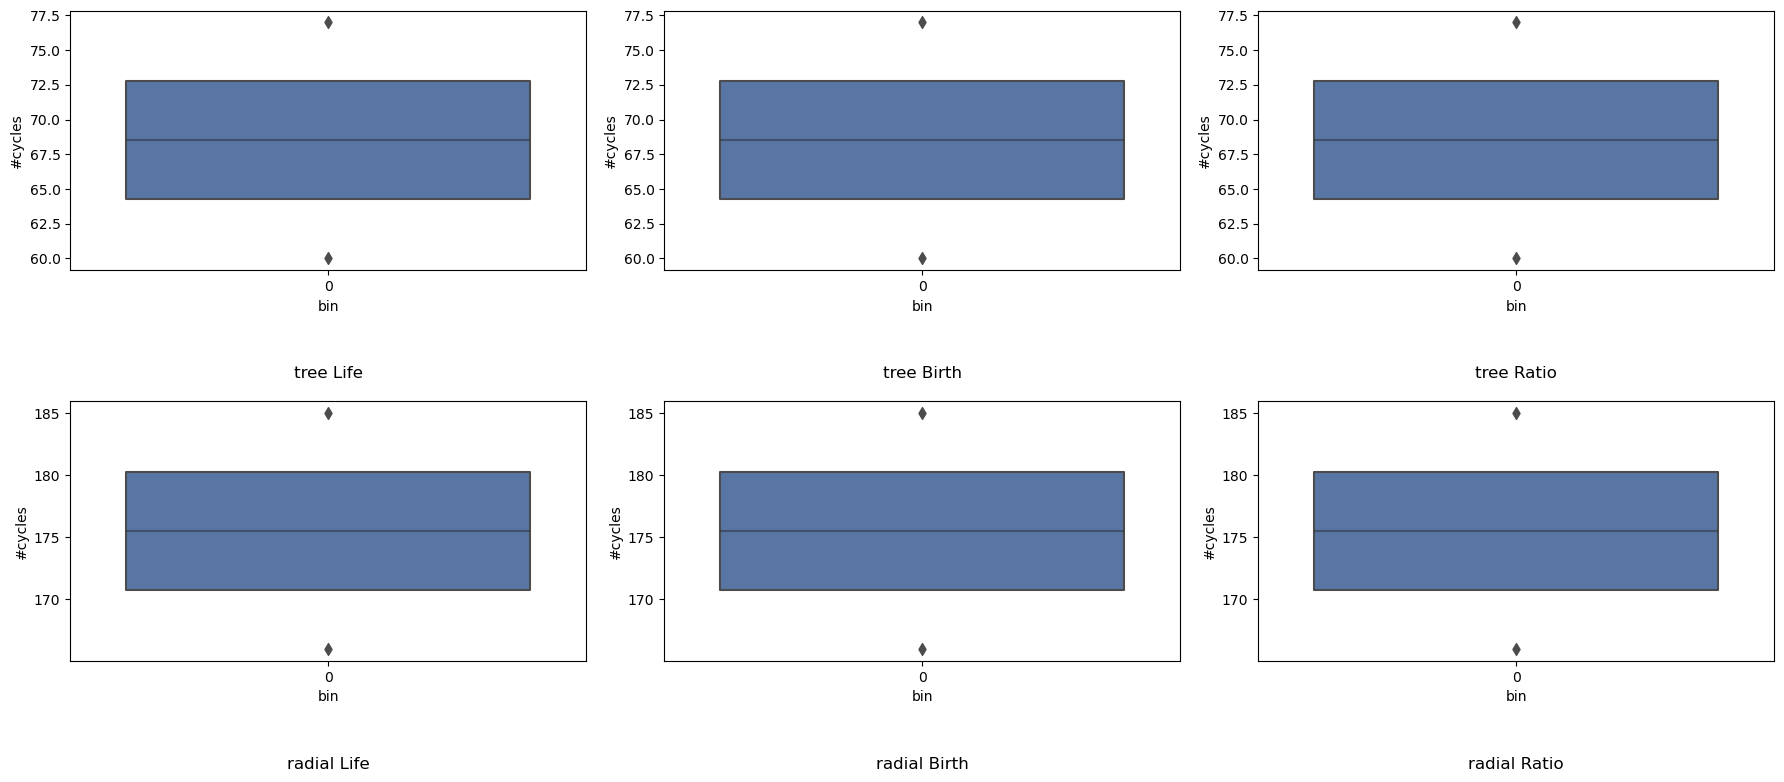

In [6]:
# boxplot
fix,ax = plt.subplots(len(modes),3,figsize=(18,8))
for i,mode in enumerate(modes):
    for j,t in enumerate(['Life','Birth','Ratio']):
        X = results[[f'{mode}_{t}_{b}' for b in range(num_bins[mode])]].values
        vboxplot(X,ax=ax[i,j],title=f'{mode} {t}')


## Result presentation
Comutation of metrics above must be executed first.

In [8]:
## select which subject to look at
results = pd.read_csv(output_csv_name)
idx = 0
metrics = results.iloc[idx]
CTID = metrics['CTID']
H = {mode: np.load(os.path.join(PH_dir[mode],f'{CTID}.npy')) for mode in modes}
metrics


CTID                 Test01
trachea_z               111
trachea_y               185
trachea_x               174
volume_gen30          73665
                      ...  
radial_Ratio_bin2       0.4
radial_Ratio_bin3       0.6
radial_Ratio_bin4       0.8
radial_Ratio_bin5       1.0
AC_gen13                NaN
Name: 0, Length: 91, dtype: object

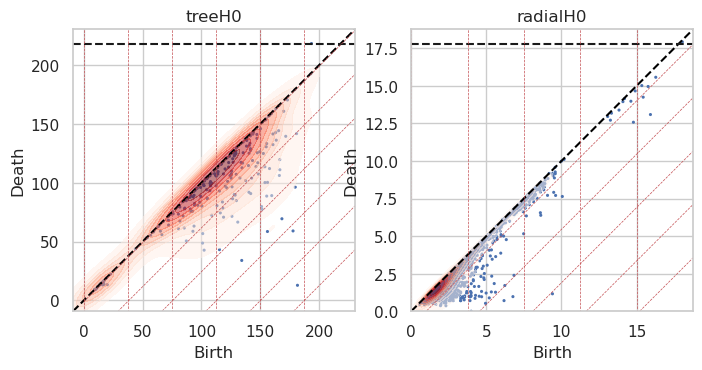

In [9]:
## plot persistence diagram
fig, ax= plt.subplots(1,2,figsize=(8,5))
persim.plot_diagrams(np.abs(H["tree"][:,1:3]),legend=False, lifetime=False, ax=ax[0],title="treeH0",size=5)
persim.plot_diagrams(np.abs(H["radial"][:,1:3]),xy_range=(0,max_birth["radial"],0,max_birth["radial"]), legend=False, lifetime=False, ax=ax[1],title="radialH0",size=5)
for k,m in enumerate(modes):
    for i in range(num_bins[m]+1):
        ax[k].plot([metrics[f'{m}_Birth_bin{i}'],metrics[f'{m}_Birth_bin{i}']], [-100,1000], '--', linewidth=0.5, c="r")
        ax[k].plot([0,1000],[-metrics[f'{m}_Life_bin{i}'],1000-metrics[f'{m}_Life_bin{i}']], '--', linewidth=0.5, c="r")
    H0tree = np.abs(H[m][:,1:3])
    H0tree = H0tree[H0tree.max(axis=1)<1e+20]
    if max_birth[m] is None:
        M=H0tree.max()
    else:
        M=max_birth[m]
    dx=H0tree.ptp()/100
    sns.kdeplot(x=H0tree[:,0], y=H0tree[:,1], shade = True, cmap = "Reds", ax=ax[k],alpha=0.5)


### Create a volume containing labels for PH cycles

use ITK-snap for visualisation: load the original CT as the main volume and the output of this as segmentation

http://www.itksnap.org/pmwiki/pmwiki.php


In [12]:
## annotation type
annot_type = 'fill' # "fill" or "line"
verbosity = 0 # print information
use_tqdm = False

# load the original volume
volume, header = nrrd.read(input_files[idx], index_order='C')
skeleton_generation,volume_generation,origin,ac_gens,skeleton_MST = dm.create_generation_volumes(volume,graph_creation="nx",threshold=threshold,min_branch_children=min_branch_children, remove_trachea=remove_trachea,verbosity=verbosity)
skeleton = (skeleton_generation>0)&(skeleton_generation<=max_gen)
binarised_volume = (volume_generation>0)&(volume_generation<=max_gen)
for annot_metric in tqdm(["life","birth","ratio"]):
    for mode in modes:
        outfn = os.path.join(output_dir,f'{CTID}_{mode}_{annot_metric}_{annot_type}_gen1-{max_gen}.nrrd') # output filename
        annotated = dm.annotated_volume(binarised_volume, skeleton, origin, metrics, H, mode, annot_type, annot_metric, min_life=min_life, max_life=max_life, num_bins=num_bins, verbosity=verbosity, use_tqdm=use_tqdm)
        nrrd.write(outfn, annotated, index_order='C')
        print(f'successfully created {outfn}')

Final graph: maximum generation 12, #connected components 1, #vertices 324, #edges 323, #leaves 163


  0%|          | 0/3 [00:00<?, ?it/s]

successfully created output_gen1-30/Test01_tree_life_fill_gen1-30.nrrd
successfully created output_gen1-30/Test01_radial_life_fill_gen1-30.nrrd
successfully created output_gen1-30/Test01_tree_birth_fill_gen1-30.nrrd
successfully created output_gen1-30/Test01_radial_birth_fill_gen1-30.nrrd
successfully created output_gen1-30/Test01_tree_ratio_fill_gen1-30.nrrd
successfully created output_gen1-30/Test01_radial_ratio_fill_gen1-30.nrrd


## Sample: correlation analysis

In [13]:
# load target class labels or other biomakers from a csv file
data_filename = "biomarkers.csv"
df = pd.read_csv(data_filename, index_col='CTID')
df = pd.merge(df,res,left_index=True, right_index=True)
df

In [ ]:
## discriminative analysis
from sklearn.model_selection import LeaveOneOut,cross_validate,StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import preprocessing,tree

# target class label
Y = df['group']

# Cross-validation method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators =10, random_state = 42, class_weight="balanced")
#clf = tree.DecisionTreeClassifier(max_depth=1,criterion="gini",random_state=42, class_weight="balanced")
for i,mode in enumerate(modes):
    for j,t in enumerate(['Life','Birth','Ratio']): # 'Birth_Life'
        nbin = num_bins[mode]**2 if t=='Birth_Life' else num_bins[mode] 
        X = df[[f'{mode}_{t}_{b}' for b in range(nbin)]].values
        scores = cross_validate(clf, X, Y, scoring=['accuracy'],cv=skf, return_estimator =True)
        print(mode,t,"accuracy:",np.mean(scores["test_accuracy"]))
        print("feature importance", sum([estimator.feature_importances_ for estimator in scores['estimator']]))
